In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/lars/libraries/keras/")
from keras.preprocessing.image import *

Using TensorFlow backend.


In [2]:
img = np.zeros((1000,1000,3))
img[400:600, 400:600, :]=1

img[300:400, 100:200, :]=1

In [68]:
def draw_boxes(img, boxes, size=10):
    draw_img = img.copy()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        dim_x, dim_y = draw_img.shape[:2]
        x_min = int(x_min * dim_x)
        x_max = int(x_max * dim_x)
        y_min = int(y_min * dim_y)
        y_max = int(y_max * dim_y)
        
        x_min = max(0, x_min)
        x_max = min(dim_x, x_max)
        y_min = max(0, y_min)
        y_max = min(dim_y, y_max)

        draw_img[x_min:x_min+size, y_min:y_max]=[1,0,0]
        draw_img[x_max-size:x_max, y_min:y_max]=[1,0,0]
        draw_img[x_min:x_max, y_min:y_min+size]=[1,0,0]
        draw_img[x_min:x_max, y_max-size:y_max]=[1,0,0]
    return draw_img

def draw_verts(img, verts, size=10):
    draw_img = img.copy()
    for vert in verts:
        
        x, y = vert
        dim_x, dim_y = draw_img.shape[:2]
        x_min = int(x * dim_x)
        x_max = int(x * dim_x)
        y_min = int(y * dim_y)
        y_max = int(y * dim_y)
        
        x_min = x_min-size
        x_max = x_max+size
        y_min = y_min-size
        y_max = y_max+size
        
        x_min = max(1, x_min)
        x_max = min(dim_x, x_max)
        y_min = max(1, y_min)
        y_max = min(dim_y, y_max)
        
        draw_img[x_min:x_max, y_min:y_max]=[0,1,0]
    return draw_img

In [69]:
def boxes_to_vertices(boxes):
    """
    Takes a list of bounding boxes and creates a list of vertices
    The output shape is [number of boxes, 4, 2]
    4 for the 4 vertices,
    2 for x/y
    :param boxes: Input tensor, must be 2D
    :return: output tensor, 3D
    """

    assert len(boxes.shape) == 2, "boxes must be a 2D tensor"
    assert boxes.shape[1] == 4, "boxes must be [:, 4] tensor"

    min_val = boxes.min()
    max_val = boxes.max()
    assert 0 <= min_val <= 1, "bounding box coordinates must be in [0,1]"
    assert 0 <= max_val <= 1, "bounding box coordinates must be in [0,1]"

    num_boxes = boxes.shape[0]

    # look at the four vertices of each box
    x_min = boxes[:, 0]
    y_min = boxes[:, 1]
    x_max = boxes[:, 2]
    y_max = boxes[:, 3]

    assert np.all(x_min < x_max), "coordinates must be given as [xmin, ymin, xmax, ymax"
    assert np.all(y_min < y_max), "coordinates must be given as [xmin, ymin, xmax, ymax"

    # create new axis to stack the x,y coordinates
    x_min = np.expand_dims(x_min, axis=-1)
    y_min = np.expand_dims(y_min, axis=-1)
    x_max = np.expand_dims(x_max, axis=-1)
    y_max = np.expand_dims(y_max, axis=-1)

    # stack the x,y coordinates to create the vertices
    # the resulting arrays are indexed [idx of box, idx of x or y]
    up_left = np.concatenate([x_min, y_min], axis=-1)
    up_right = np.concatenate([x_min, y_max], axis=-1)
    down_right = np.concatenate([x_max, y_max], axis=-1)
    down_left = np.concatenate([x_max, y_min], axis=-1)

    # now stack the vertices, along axis 1
    up_left = np.expand_dims(up_left, axis=1)
    up_right = np.expand_dims(up_right, axis=1)
    down_right = np.expand_dims(down_right, axis=1)
    down_left = np.expand_dims(down_left, axis=1)

    # create an array of all vertices, of all boxes
    # the shape is [number of boxes, number of vertices, number of coordinates]
    # ->  shape is [number of boxes, 4, 2]
    vertices = np.concatenate([up_left, up_right, down_right, down_left], axis=1)

    return vertices

def vertices_to_boxes(vertices):
    """
    Takes a list of vertices and converts them to bounding boxes
    :param vertices: Input tensor, must be 2D
    :return: output tensor, 2D
    """

    assert len(vertices.shape)==2, "vertices must be a 2D tensor"
    assert vertices.shape[1]==2, "vertices must be [:, 2] tensor"

    vertices = vertices.reshape((-1, 4, 2))

    x = vertices[:, :, 0]
    y = vertices[:, :, 1]

    x_min = x.min(axis=-1)
    x_max = x.max(axis=-1)
    y_min = y.min(axis=-1)
    y_max = y.max(axis=-1)

    x_min = np.expand_dims(x_min, axis=-1)
    x_max = np.expand_dims(x_max, axis=-1)
    y_min = np.expand_dims(y_min, axis=-1)
    y_max = np.expand_dims(y_max, axis=-1)

    boxes = np.concatenate([x_min, y_min, x_max, y_max], axis=-1)

    return boxes

In [70]:
boxes = np.array([[0.4, 0.4, 0.6, 0.6],
                 [0.3, 0.1, 0.4, 0.2]])

vertices = boxes_to_vertices(boxes)
vertices = vertices.reshape((-1, 2))

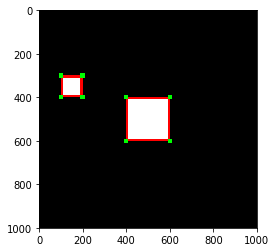

In [71]:
draw_img =draw_boxes(img, boxes, 10)
draw_img = draw_verts(draw_img, vertices, 10)
plt.imshow(draw_img)

In [87]:
row_axis = 0
col_axis = 1
channel_axis = 2
fill_mode = "nearest"
cval = 0.

zoom_range=(0.5,1.5)

if zoom_range[0] == 1 and zoom_range[1] == 1:
    zx, zy = 1, 1
else:
    zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    
zx = 0.5
zy = 0.2
zoom_matrix = np.array([[zx, 0, 0],
                        [0, zy, 0],
                        [0, 0, 1]])

h, w = img.shape[row_axis], img.shape[col_axis]
transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
new_img = apply_transform(img, transform_matrix, channel_axis, fill_mode, cval)

In [88]:
# apply to vertices
new_vertices = boxes_to_vertices(boxes.copy())
new_vertices = new_vertices.reshape((-1, 2))

"""
homog_vertices = np.ones((vertices.shape[0], 3))
homog_vertices[:,:2]=vertices

offset_matrix = np.array([[1,0,-0.5], [0,1,-0.5], [0,0,1]])
zoom_matrix = np.array([[zy, 0, 0],
                        [0, zx, 0],
                        [0, 0, 1]])
reset_matrix = np.array([[1,0,0.5], [0,1,0.5], [0,0,1]])
v_matrix = np.dot(np.dot(offset_matrix, zoom_matrix), reset_matrix)

homog_vertices = np.dot(homog_vertices, v_matrix)
homog_boxes = vertices_to_boxes(homog_vertices[:, :2])
"""
# apply offset to have pivot point at [0.5, 0.5]
new_vertices -= [0.5, 0.5]

# apply zoom, we only need the zoom part of the matrix
new_vertices *= [1/zx, 1/zy]
new_vertices += [0.5, 0.5]

new_boxes = vertices_to_boxes(new_vertices)


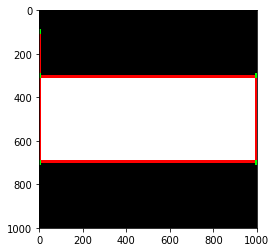

In [89]:
draw_img = draw_boxes(new_img, new_boxes)
draw_img = draw_verts(draw_img, new_vertices)
plt.imshow(draw_img)

In [80]:
new_vertices

array([[ 0.42065316,  0.41818683],
       [ 0.42065316,  0.58181317],
       [ 0.57934684,  0.58181317],
       [ 0.57934684,  0.41818683],
       [ 0.34130631,  0.1727473 ],
       [ 0.34130631,  0.25456048],
       [ 0.42065316,  0.25456048],
       [ 0.42065316,  0.1727473 ]])